In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

def st_scatter_ax(ax, x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [4]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [5]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240228"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [6]:
from merfish_datasets import merfish_datasets
import json

directories = merfish_datasets
print(merfish_datasets)

name = 'P28DR_ant'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
fout = full_dirc+'detected_transcripts_v1l23fovs.csv'

f1 = full_dirc+'detected_transcripts.csv'
df = pd.read_csv(f1, nrows=1000)

f2 = full_dirc+'cell_metadata.csv'
df2 = pd.read_csv(f2, index_col=0)
df2['cell_id'] = df2.index


{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [7]:
f_main = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240318.h5ad'
f_meta = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240318_xy_operations.json'

adata = ad.read(f_main)
bound_l, bound_r, bound_d = 2500, 4000, 400
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]
adatasub
# df

    

View of AnnData object with n_obs × n_vars = 1306 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DreO_raw', 'DreO_high_pass', 'Cre_raw', 'Cre_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'FlpO_raw', 'FlpO_high_pass', 'Pvalb_raw', 'Pvalb_high_pass', 'Sst_raw', 'Sst_high_pass', 'Fth1_raw', 'Fth1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'depth', 'width'
    obsm: 'blanks', 'pca'
    layers: 'norm'

In [8]:
with open(f_meta, 'r') as fh:
    xy_operations = json.load(fh)
    rotation_angle = xy_operations['rotation']
    ref_line = np.array(xy_operations['ref_line'])
    
print(rotation_angle)
print(ref_line.shape)

-90
(100, 2)


In [9]:
# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((23,),
 array([1153, 1154, 1155, 1156, 1170, 1171, 1172, 1173, 1174, 1175, 1176,
        1177, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1195, 1196,
        1197]))

In [10]:

chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)
           

0 1.6718251705169678
1 2.977811813354492
2 4.274818420410156
3 5.620757579803467
4 6.875186443328857
5 8.16858983039856
6 9.498761892318726
7 10.553250551223755
8 11.619463920593262
9 12.832999229431152
10 14.201811075210571
11 15.42391848564148
12 16.748600482940674
13 18.292391777038574
14 19.597435235977173
15 20.973757028579712
16 22.162182092666626
17 23.395185232162476
18 24.658199787139893
19 26.052891969680786
20 27.23765802383423
21 28.949456214904785
22 30.35383915901184
23 31.67630362510681
24 33.01107621192932
25 34.31131386756897
26 35.862065076828
27 37.7251501083374
28 39.16674017906189
29 40.85446381568909
30 42.46004843711853
31 43.78928828239441
32 45.285805225372314
33 46.912166357040405
34 48.337615966796875
35 49.97263145446777
36 51.4203896522522
37 52.93751335144043
38 54.35857367515564
39 56.054511070251465
40 57.582969665527344
41 59.17022132873535
42 60.83584785461426
43 62.24997115135193
44 63.90919518470764
45 65.51342868804932
46 67.13550615310669
47 68.578

In [11]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
50826053,21,0,3690.3184,9999.110,0.0,720.2441,116.15169,1153,Cdh4,ENSMUST00000000314,4207478901109100059
50826054,26,0,3695.7678,10002.117,0.0,770.7033,143.98760,1153,Cdh4,ENSMUST00000000314,4207478901109100059
50826055,55,0,3709.5159,10026.095,0.0,898.0000,366.00000,1153,Cdh4,ENSMUST00000000314,-1
50826056,71,0,3817.9000,10036.284,0.0,1901.5549,460.34763,1153,Cdh4,ENSMUST00000000314,-1
50826057,79,0,3695.2417,10044.341,0.0,765.8310,534.94580,1153,Cdh4,ENSMUST00000000314,4207478901155100049
...,...,...,...,...,...,...,...,...,...,...,...
54969877,41,432,3208.4700,10982.779,6.0,1910.8652,1772.14480,1197,Egr1,ENSMUST00000165033,4207478901473100025
54969878,360,433,3209.0798,10981.716,6.0,1916.5120,1762.29770,1197,Klf3,ENSMUST00000165536,4207478901473100025
54969879,11,453,3212.5884,10826.289,6.0,1949.0000,323.15833,1197,Apoe,ENSMUST00000174064,4207478901427100020
54969880,61,453,3205.9630,10979.325,6.0,1887.6530,1740.15940,1197,Apoe,ENSMUST00000174064,4207478901473100025


In [12]:
df_v1l23.to_csv(fout, header=True, index=False)
# !head $fout

In [13]:
a = df_v1l23[df_v1l23['gene']=='Cdh13']
b = df_v1l23[df_v1l23['gene']=='Sorcs3']
c = df_v1l23[df_v1l23['gene']=='Chrm2']
print(a.shape, b.shape, c.shape)

(1807, 11) (1618, 11) (948, 11)


<Axes: xlabel='global_x', ylabel='global_y'>

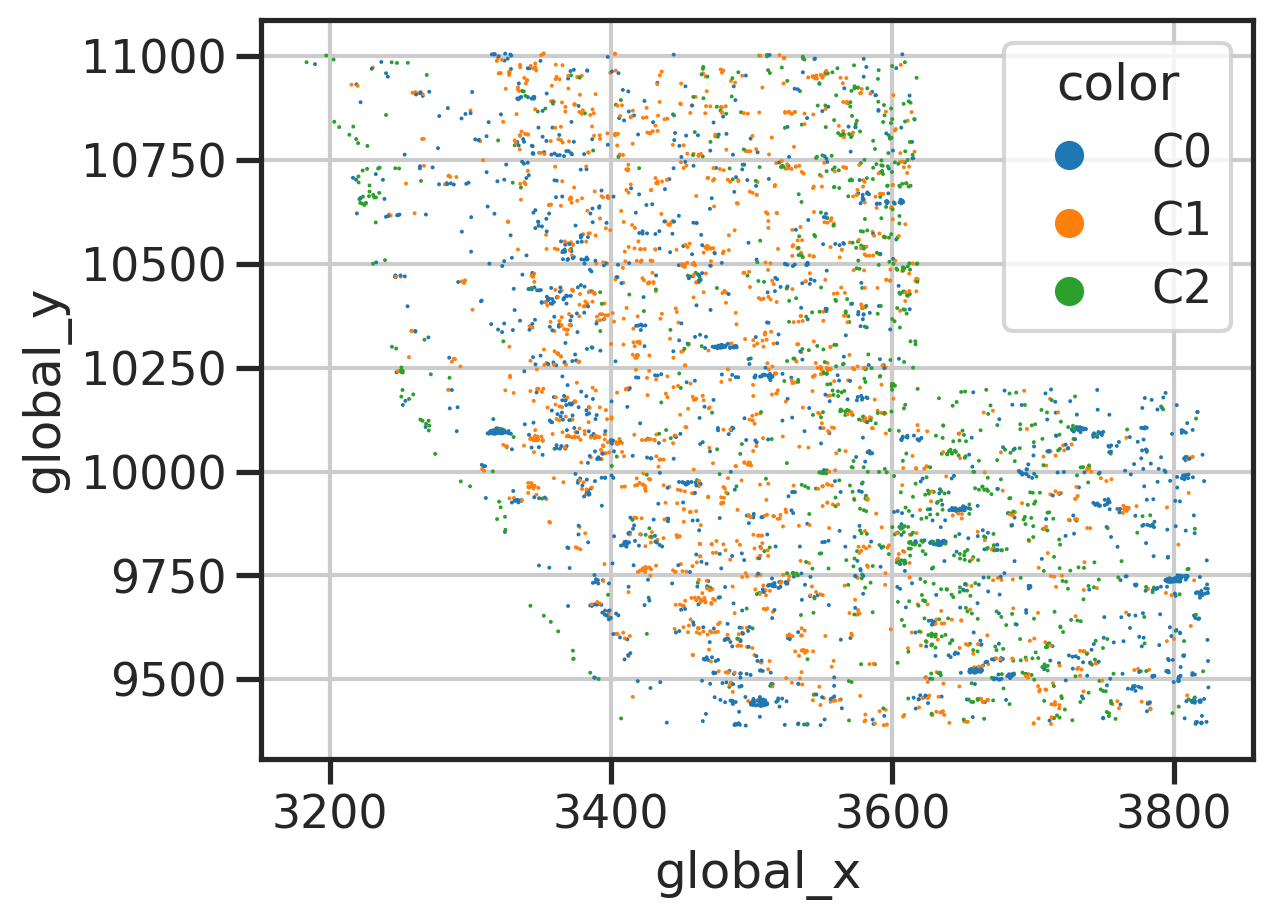

In [14]:
abc = pd.concat([a,b,c])
abc['color'] = ['C0']*len(a)+['C1']*len(b)+['C2']*len(c)
sns.scatterplot(data=abc.sample(frac=1, replace=False), x='global_x', y='global_y', hue='color', hue_order=['C0', 'C1', 'C2'], s=2, edgecolor='none')

# get rotation and ref line
# calculate the width and the depth as cells

In [15]:
# depth ref
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [16]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)].copy()

x = abc['global_x'].values
y = abc['global_y'].values
xr, yr = rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 
print(len(abc))

abc['x'] = xr
abc['y'] = yr
abc['depth'] = ref_line_obj.ndist_to_qps(XY)
abc['width'] = ref_line_obj.tdist_to_qps(XY)


cond_spots = np.all([
    abc['width'] > bound_l, 
    abc['width'] < bound_r, 
    abc['depth'] < bound_d, 
], axis=0)

abc = abc[cond_spots]
print(len(abc))
abc.value_counts('gene').reindex(query_genes) 

4373
3240


gene
Cdh13     1289
Sorcs3    1305
Chrm2      646
dtype: int64

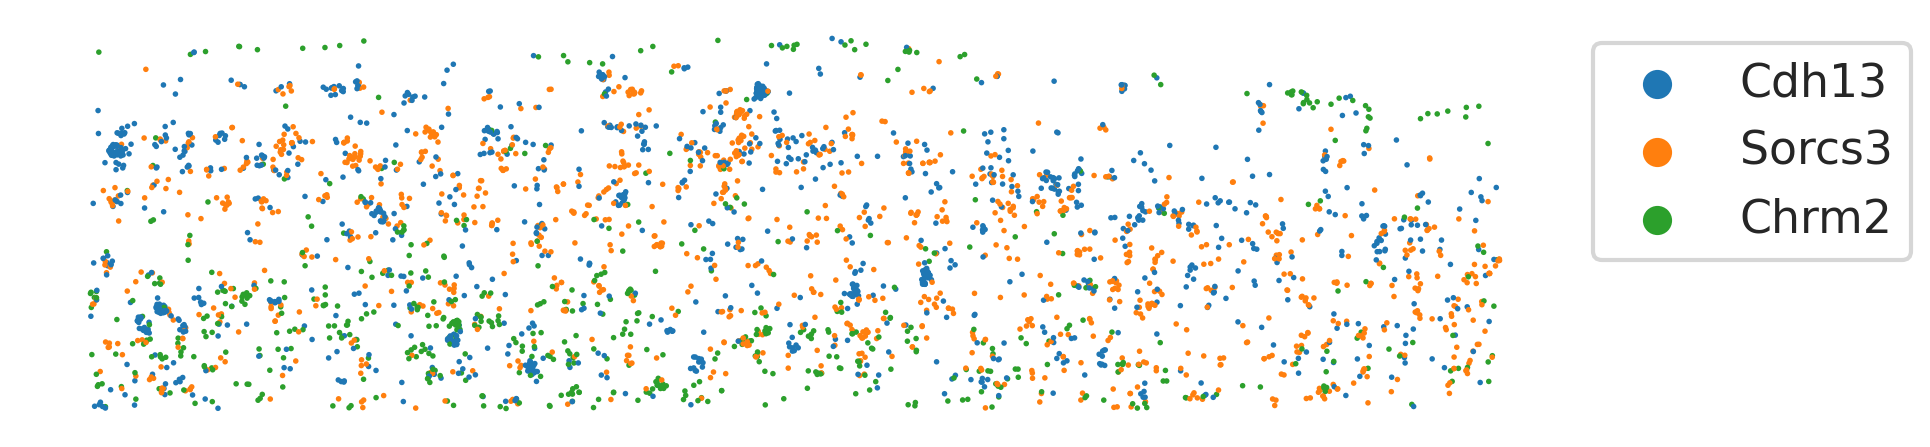

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()